1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from pandas import Series, DataFrame

df = pd.read_csv("https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv")
df = df.drop(columns='Unnamed: 0')
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [3]:
df['default'] = df['default'].replace("No",0).replace("Yes",1)
df['student'] = df['student'].replace("No",0).replace("Yes",1)
df.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

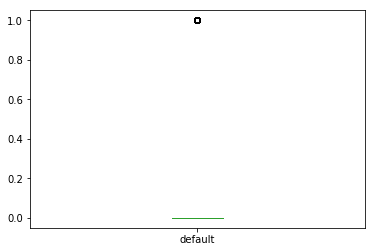

In [4]:
df['default'].plot.box()
plt.show()

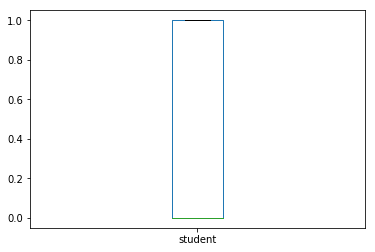

In [5]:
df["student"].plot.box()
plt.show()

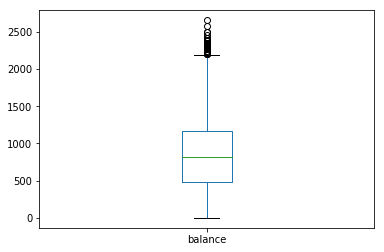

In [6]:
df['balance'].plot.box()
plt.show()

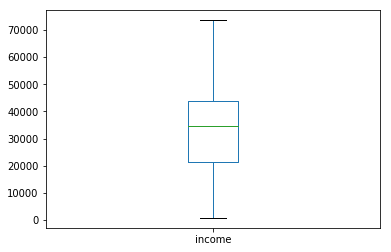

In [7]:
df['income'].plot.box()
plt.show()

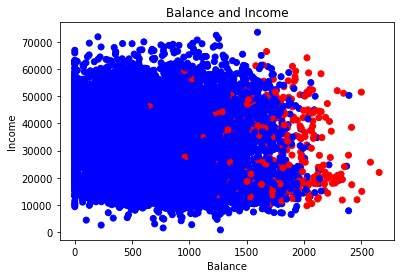

In [8]:
colors= {0:"blue",1:"red"}
plt.figure()
plt.scatter(df["balance"],df["income"],c = df["default"].apply(lambda x:colors[x]))
plt.title("Balance and Income")
plt.xlabel("Balance")
plt.ylabel("Income")
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

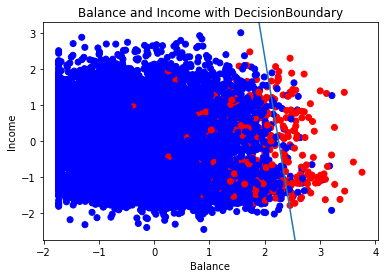

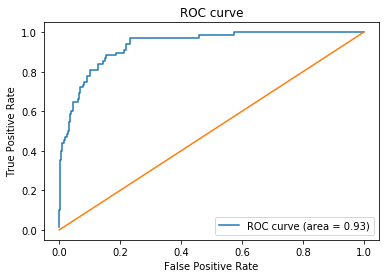

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df[['balance','income']]
Y = df['default']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2,random_state = 10)

RL = LogisticRegression(penalty='l1')
model1 = RL.fit(X_train,Y_train)

colors = {0:'blue',1:'red'}
fig, ax = plt.subplots()

ax.scatter(X[:,0],X[:,1],c = df['default'].apply(lambda x:colors[x]))
plt.title('Balance and Income with DecisionBoundary')
plt.xlabel('Balance')
plt.ylabel('Income')

k = model1.intercept_
coef = model1.coef_[0]
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
x = np.arange(xmin,xmax)
y = (k+coef[0]*x)/-coef[1]

plt.plot(x,y)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.show()


from sklearn.metrics import auc, roc_curve
from sklearn.datasets import make_classification
Y_predict = RL.predict(X_test)
Y_score = model1.decision_function(X_test)
fpr,tpr,_ = roc_curve(Y_test,Y_score)
roc_auc = auc(fpr,tpr)

plt.figure()
plt.plot(fpr,tpr,label='ROC curve (area = %0.2f)'%roc_auc)
plt.plot([0,1],[0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc = 'lower right')
plt.show()


5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

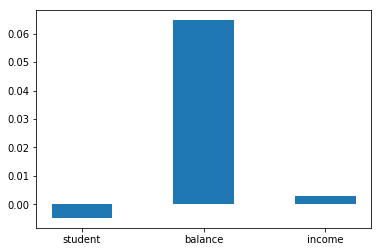

The coefficients: [-0.00483573  0.06472572  0.00296429]


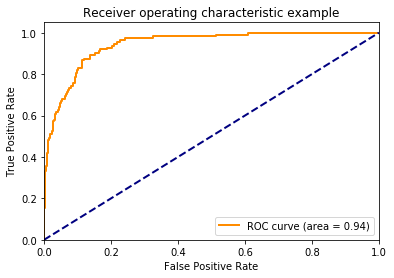

The performance after add one variable is not significantly better than before.


In [10]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

X = df[['student','balance','income']]
y = df['default']

# standardize before using Ridge
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10) # test size can influence alpha

alpha = np.logspace(-5, -1, 100)
score=[]
for i in alpha:
    clf = Ridge(alpha = i)
    clf.fit(X_train, y_train)
    score.append(clf.score(X_test, y_test))
index = np.array(score).argmax()

clf = Ridge(alpha = alpha[index])
clf.fit(X_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(np.arange(3), clf.coef_, 0.5)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(('student', 'balance','income'))
rects = ax.patches
plt.show()
print ('The coefficients:',clf.coef_)

# train and test data
X = df[['student','balance','income']]
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=10)


LogReg = LogisticRegression(penalty='l1', C= alpha[index])
clf = LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)

# Compute ROC curve and ROC area 
y_score = clf.decision_function(X_test)
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
#plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print("The performance after add one variable is not significantly better than before.")

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

In [11]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(RL, X_train, y_train, cv=6)
print(scores)
print('According the validation scores look like all approaching 0.97, the model is robust.')

[0.97686375 0.97429306 0.97172237 0.97257926 0.97600686 0.97253219]
According the validation scores look like all approaching 0.97, the model is robust.


7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

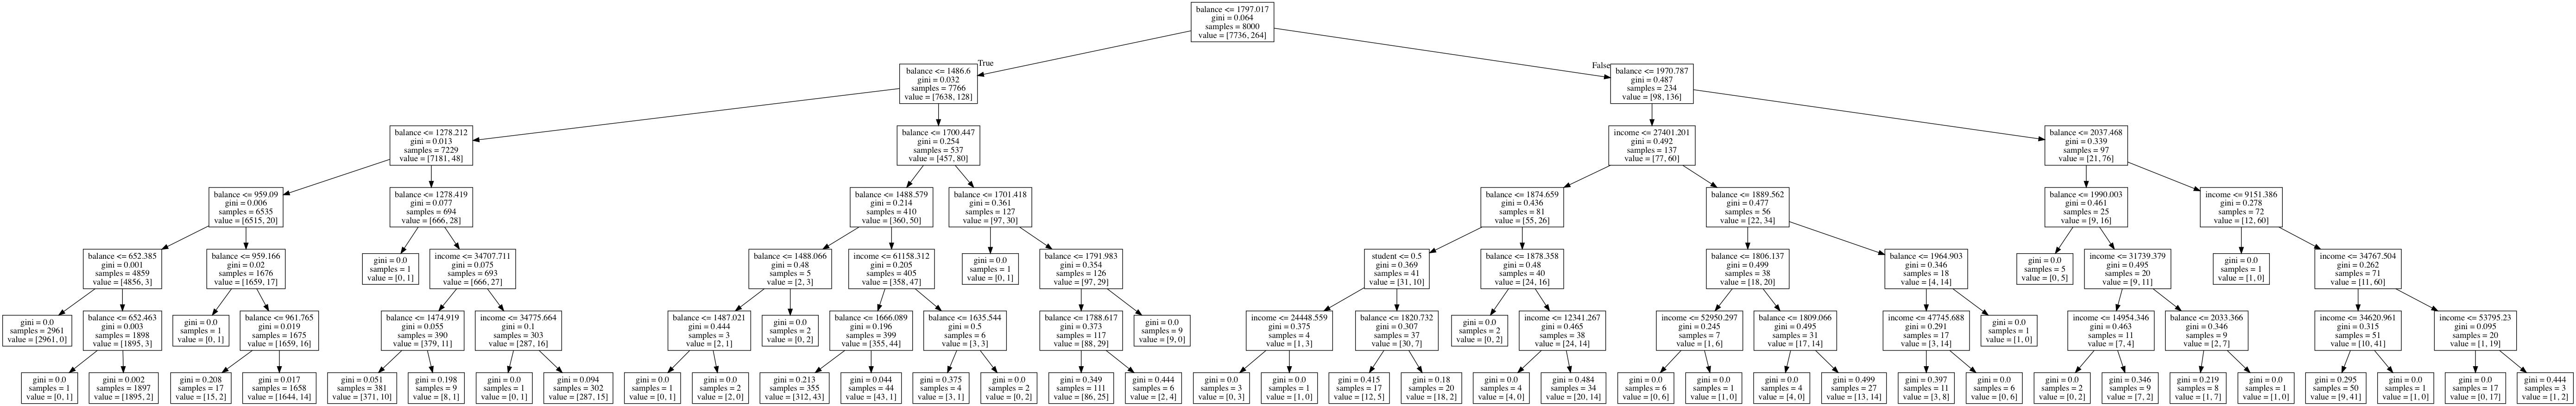

In [12]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydotplus

X = df.drop(["default"],1)
y = df.default
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

dt=DecisionTreeClassifier(max_depth=6)
dt.fit(X_train, y_train)

dot_data = StringIO()  
export_graphviz(dt, out_file=dot_data, feature_names=X_train.columns)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

8) Find the optimal decision tree depth and compute the AUC ROC. 

Optimal Depth: 5.


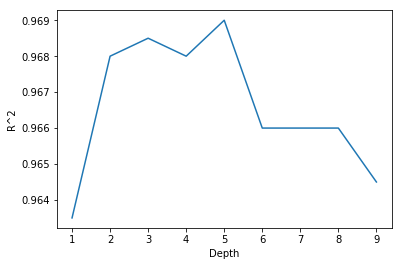

In [13]:
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,10)
for n in depths:
    dt = DecisionTreeClassifier(max_depth=n)
    # Train the model using the training sets
    dt.fit(X_train, y_train)
    train_errors.append(dt.score(X_train,y_train))
    scores.append(dt.score(X_test,y_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores)
test_errors = scores
n_opt = depths[np.argmax(scores)]
print("Optimal Depth: {0}.".format(n_opt))
plt.show()

Area under the ROC curve : 0.932550


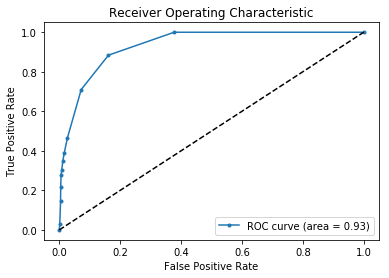

Max Depth = 4
Area under the ROC curve : 0.921757


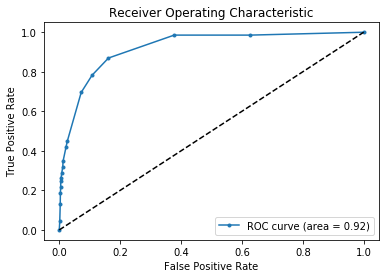

Max Depth = 5
Area under the ROC curve : 0.893049


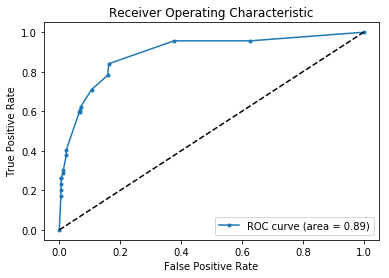

Max Depth = 6
According to ROC figures, the depth of 4 seems a little bit better than the depth of 5.


In [15]:
def generate_auc(X,y,clf_class,**kwargs):

    random_state = np.random.RandomState(0)
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 4)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 4')


fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 5)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 5')


fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 6)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 6')

print('According to ROC figures, the depth of 4 seems a little bit better than the depth of 5.')